# Description
- Add station to plots (done)
- Overlay importance area and predictor map (done)
- Fix Colorbar to certain values in order to compare figures (done). Make the upper limit to storm extremes etc. (done)
    - At first I chose 95% of max min values but I dont think this is the best choice to see extremes. Go abit lower. Used the following values now with 10 levels
    - sp: unit (Pa), reasonable vmax = 104000 , vmin = 74000, 
    - tp: unit (m), reasonable vmax = 0.0018 , vmin = 0, 
    - u10: unit (m/s), reasonable vmax = 17 , vmin = -17, (17.2 m/s is def of stormy winds)
    - v10: unit (m/s), reasonable vmax = 17, vmin = - 17, 
    
- Preprocess: Turn PA into hPa (done)
- Colormap for each predictor? (done)
- Rearange colorbar_range again. look in my theory part for values (done)
- Setup a function for future model runs (done)
    - Check if it works for multiple model inputs (done)
    
- Sort into modules (done)
- Detrend by subtracing trend: gesla_preprocessing.detrend(method="mean") or method="trend" etc.
- Setup new predictor: Prefilling measured at Degerby.
- Apply new model-runs
- Analyze results of rf010 while other models run
- lon lats puts to screen that sp as a predictor is imported even though for prediction a different predictor is used. Either delete the message or relaod lon/lats for each predictor.

# Main and Testmain

In [9]:
#---
# Modules
#---
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

from models import modelfit
from models import evaluation
from models import loader

In [6]:
#---
# Initialize
#---
model_run = "rf014"
run_id = 0
season = "winter"
station_names = ["hanko-han-fin-cmems",]
predictors_of_model = [
    # ["sp",], # rf013
    # ["tp",],
    # ["u10",],
    # ["sp"],
    # ["tp",],
    # ["u10",],
    # ["sp"],
    # ["tp",],
    # ["u10",],
    ["sp",], # rf014
    ["tp",],
    ["u10",],
]
timelags_of_model = [
    # [0,], #rf013
    # [0,],
    # [0,],
    # [2,],
    # [2,],
    # [2,],
    # [4,],
    # [4,],
    # [4,],
    [2,], #rf014
    [2,],
    [2,],
]
models_path = [
    # None, #rf013
    # None,
    # None,
    # None,
    # None,
    # None,
    # None,
    # None,
    # None,
    None, #rf014
    None,
    None,  
]
percentile = 0.95
clf = RandomForestClassifier

# Build Hyperparameter Grid to optimize from.
#---
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 10)] # Number of trees in random forest
max_depth = [int(x) for x in np.linspace(1, 4, num = 4)] # Maximum number of levels in tree

# max_depth.append(None)
# min_samples_split = [2, 5,] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
random_state = 0

hparam_grid = {'n_estimators': n_estimators, # hparam grid if optimization is needed
            'max_depth': max_depth,
            # 'min_samples_split': min_samples_split,
            # 'min_samples_leaf': min_samples_leaf,
            'criterion' : ['gini',],
            'random_state' : [random_state,], # To compare results when changing hyperparameters
            'class_weight' : ["balanced",], # “balanced_subsample"
            'oob_score' : [True,],
            }

optimizer = "GridSearchCV" #"RandomSearchCV"
k = 3
n_iter = 100 
test_size = 0.25
is_optimized = True # TODO: Maybe adjust this to be a list as predictor_of_models etc. s.t. one can decide whether to optimize or just load a model
is_scaled = False
is_overlay_importance = True
is_station_name = False 

In [7]:
#---
# Main
#---
def run(
model_run, 
run_id, 
season,
station_names, 
predictors_of_model, 
timelags_of_model, 
models_path, 
percentile, 
clf, 
hparam_grid, 
optimizer, 
k, 
n_iter, 
random_state,
test_size,
is_optimized, 
is_scaled,
is_overlay_importance,
is_station_name,
):
    """
    Description:
        Builds a model to predict (percentile) extreme storm surges at station_names using predictors for a specified season by using
        a classifier.
    Parameters:
        season (str): Either winter or autumn
        predictors (list): List of predictors (X) used to predict Storm Surge (y)
        percentile (float): Percentile of Extreme Storm Surges
        station_names (list): List of stations used from GESLA data-set
        clf (sklearn.modeltype): Used model to do prediction, e.g. RandomForestClassifier, LogisticRegression,...
        hparam_grid (dict): Selection of multiple Hyperparameters either used for building the model or fitted 
                            to clf via the optimizer depending on is_optimized.
                            If hparam_grid is used for optimization, values of dictionary need to be lists.
        optimizer (str): Optimizer for automatic search of hyperparameters, either GridSearchCV or RandomSearchCV
        run_id (int): Number of the run (used for saving output)
        model_run (str): Naming of the model run (used for saving output)
        k (int): Number of k-fold crossvalidations in model fit (Defaults: 3)
        n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults: None)
        is_optimized (bool): Whether or not to search best combination of hparams within hparam_grid with 
                             the optimizer (Defaults: True)
                             If is_optiomized == False, hyperparameters are loaded from a model given in models_path
        is_scaled (bool): Use StandardScaler to scale data if it is on different scales (Defaults: False)
    Returns:
        None. Saves Output in results>random_forest>model_run folder. Saves model in models>random_forest>model_run
    """
    import sys
    #--- 
    # Initialize
    #---
    preprocess = "preprocess1" # ["preprocess1"]
    range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
    subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
    lats, lons = preprocessing.get_lonlats(
        range_of_years,
        subregion,
        season,
        predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
        era5_import=preprocess,
        )
    colorbar_range = { # vmin vmax values for colorbar of predictor maps
        'sp': np.array([ 980., 1020.,]),  # Low pressure systems <980hPa (see Theory Part)
        'tp': np.array([0.    , 0.0018]),
        'u10': np.array([-17.2,  17.2]), # Storm is defined by wind stronger than 17.2m/s
        'v10': np.array([-17.2,  17.2]),
        }
    nlevels = 10 # For contourplot of predictor maps
    orig_stdout = sys.stdout # Original Output for print etc.
    

    #---
    # Preprocess GESLA Data
    #---

    # Load Predictand
    #---
    gesla_predictand = data_loader.load_gesla(station_names)

    # Get lon/lat positions of stations
    #---
    station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

    # Select a season
    #---
    gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

    # Select only sea_level analysis data
    #---
    gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
    gesla_predictand = gesla_predictand["sea_level"] # Select values

    # Detrend 
    #---
    gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station",) # TODO: Make it possible to detrend by subtracting trend instead of mean

    # Apply one hot encoding
    #---
    gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
    print(f"Applied one-hot-encoding with Percentile: {percentile}")

    # Convert to DataArray
    # nan values: no measurement at that timestamp for specific station
    #---
    gesla_predictand = gesla_predictand.to_xarray()

    #---
    # Loop over all run_ids of a model_run / predictors
    #---
    for idx, predictors in enumerate(predictors_of_model): # Loops over separate modelruns 

        # #---
        # # Save printed output to file
        # #---
        folder = f"results/random_forest/{model_run}/"
        saver.directory_existance(folder)
        file_path = f'{folder}output_runid{run_id}.txt'
        sys.stdout = open(file_path, "w") 

        #---
        # Load ERA5- Predictor
        #---
        
        # Initialize
        #---
        timelags = timelags_of_model[idx]
        X = []
        Y = []
        t = []
        pred_units = []
        pred_names = []

        # Main
        #---
        for predictor in predictors:
            print(f"Add predictor {predictor} to model input features")

            # Load data of predictor
            #---
            era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
            era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
            
            # Convert predictor sp.unit from Pa to hPA
            #---
            if predictor == "sp":
                with xr.set_options(keep_attrs=True):
                    old_unit = era5_predictor.attrs["units"]
                    era5_predictor = era5_predictor / 100
                    era5_predictor.attrs["units"] = "hPa"
                    new_unit = era5_predictor.attrs["units"]
                    print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
                    
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand)

            print(f"Introduce timelags: {timelags}")
            
            X_timelag, Y_timelag = preprocessing.combine_timelags(X_, Y_, timelags)

            X.append(X_timelag)
            Y.append(Y_timelag)
            t.append(t_)

            # Save unit and name of predictor
            #---
            for timelag_ in timelags:
                pred_units.append(era5_predictor.units)
                pred_names.append(f"{era5_predictor.name}_tlag{timelag_}")

        # Convert to format needed for model fit
        #---      
        X = np.array(X)
        Y = np.array(Y) 
        Y = Y[0, :] # Assume all timeseries are the same for the predictors.
        t = np.array(t)

        # Reshape for model input
        #---
        print(f"Reshape for model input")

        ndim = Y.shape[0]

        X = X.swapaxes(0, 2) # Put time dimension to front

        print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

        X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
        y = Y[:, 0] # Select one station

        #---
        # Handle NaN Values
        #---

        # Insert numerical value that is not in data.
        # ML will hopefully recognize it.
        X[np.where(np.isnan(X))] = -999

        print("Data is prepared as follows")
        print(f"X.shape : {X.shape}")
        print(f"y.shape : {y.shape}")
        print(f"pred_names : {pred_names}")
        print(f"pred_units : {pred_units}")

        #---
        # Apply Train-Test split 
        #---
        print("Apply train-test-split")
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)

        # ---
        # Detrend train-test sets separately
        # ---

        # # Convert to expected format 
        # #---
        # test_index = np.zeros(y_test.shape).astype(int) # All zeros because we only selected one station
        # train_index = np.zeros(y_train.shape).astype(int)

        # y_test = array_to_series(y_test, test_index, index_name="station", series_name="sea_level") # DONE: Add do module: Preprocessing
        # y_train = array_to_series(y_train, train_index, index_name="station", series_name="sea_level")

        # # Detrend
        # # ---
        # print("Detrend train-test data for predictand")
        # y_test = gesla_preprocessing.detrend(y_test, level="station")
        # y_train = gesla_preprocessing.detrend(y_train, level="station")

        # # # Apply one hot encoding
        # #---
        # y_test = gesla_preprocessing.apply_dummies(y_test, percentile=percentile, level="station")
        # print(f"Applied one-hot-encoding to test-set with Percentile: {percentile}")

        # y_train = gesla_preprocessing.apply_dummies(y_train, percentile=percentile, level="station")
        # print(f"Applied one-hot-encoding to train-set with Percentile: {percentile}")

        # print(f"{y_train.size} training datapoints used")
        
        # # Convert to DataArray
        # # nan values: no measurement at that timestamp for specific station
        # #---
        # y_test = y_test.to_xarray()
        # y_train = y_train.to_xarray()
        
        #---
        # Scale data if they are on different scales
        #---
        if is_scaled:
            print("Scale training data")
            s = StandardScaler()
            s.fit(X_train)
            X_train = s.transform(X_train)
            X_test = s.transform(X_test)

        #---
        #  Optimize Hyperparameters
        #---
        if is_optimized:
            print(f"Optimize Hyperparameters using {optimizer}")
            print(f"Tested Hyperparameters: {hparam_grid}")
            
            hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)
        
        if not is_optimized:
            model_path = models_path[idx]
            print(f"Hyperparameters are loaded from model: {model_path}")
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            hparam_grid_opt = model.get_params()
            
        #---
        #  Save hyperparameters
        #---
        folder = f"models/random_forest/{model_run}/" 
        saver.directory_existance(folder)
        saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

        print("Saved Hyperparameters")

        #---
        # Fit the model
        #---
        print(f"Fit model with hyperparameters {hparam_grid_opt}")

        model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

        model.fit(X_train, y_train)

        #---
        # Saving the model
        #---
        print("Save model")
        filename = f'{model_run}_{optimizer}_{run_id}.sav'
        pickle.dump(model, open(f'{folder}{filename}', 'wb'))

        #---
        # Plot Predictor Maps
        #---
        visualisation.predictor_maps(
            model, X_test, y_test, 
            lons, lats, pred_units, pred_names, 
            station_positions, station_names, is_station_name, 
            is_overlay_importance, 
            run_id, model_run, 
            percentile=99., markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,
            )
        
        #---
        # Evaluate model / Diagnostic
        #--- 
        print("Evaluate Model \n")

        # Score & Importance
        #---
        test_score = model.score(X_test, y_test)
        train_score = model.score(X_train, y_train)
        relative_score = evaluation.relative_scores(train_score, test_score)
        importance = model.feature_importances_

        # Save Scores & Importance
        #---
        folder = f"results/random_forest/{model_run}/"
        saver.directory_existance(folder)

        fname = f"importance_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", importance)
        print(f"saved importance to : {folder}{fname}")

        fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", test_score)
        print(f"saved testscore to : {folder}{fname}")

        fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", train_score)
        print(f"saved trainscore to : {folder}{fname}")

        fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", relative_score)
        print(f"saved relativescore to : {folder}{fname}")

        # Plot importance of each predictor from combination
        # Goal:
        # 1. Separate importance per predictor
        # 2. Plot importance of each predictor on lon lat map
        #---
        n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

        predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

        for pred_idx, pred_importance in enumerate(predictor_importances):
            # Plot importance map and save it
            predictor = pred_names[pred_idx] 
            tflag = f"{predictor}_{str(percentile)[-2:]}"

            fig, ax = evaluation.importance_map(pred_importance, lons, lats, tflag)
            
            # Add position of station to map
            #---
            for station_name in station_names:
                visualisation.plot_station(ax, station_positions, station_name, is_station_name)
                
            fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
            fig.savefig(f"{folder}{fname}.pdf")

        #---
        # Confusion matrix
        #---
        # Format: 
        # Reality / Model: Negative, Positive
        # Negative    Right Negative, False Positive 
        # Positive    False Negative, Right Positive

        print("Show Confusion Matrix on testdata \n")
        cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
        cfm_fig1.show()

        print("Show Confusion Matrix on traindata \n")
        cfm_fig2 = evaluation.plot_cf(model, X_train, y_train)
        cfm_fig2.show()

        # Save CFM
        fname = f"{folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig1.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        fname = f"{folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig2.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        # Calculate CFM-Metrics
        metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
        metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

        fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics1, f)

        fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics2, f)

        print(f"saved cf metrics to : {fname}")

        #---
        # AUROC
        # Receiver Operating Characteristics & Area Under the Curve
        #---

        print("Show AUROC \n")

        y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
        auc = roc_auc_score(y_test, y_test_proba)

        print(f'AUC: {auc}')

        fig, ax = plt.subplots(tight_layout=True)

        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"AUROC with AUC = {auc}")

        fig.show()

        fname = f"{folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
        fig.savefig(fname)
        print(f"saved AUROC to : {fname}")

        #---
        # Update run_id
        #---
        run_id = run_id + 1
        sys.stdout = orig_stdout # Restore original system output

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Created directory: results/random_forest/rf014/


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

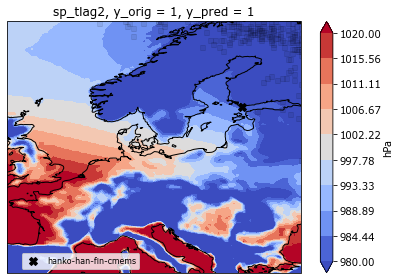

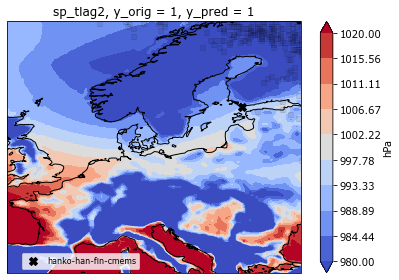

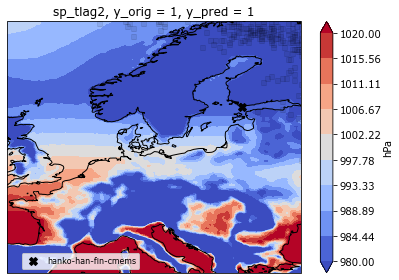

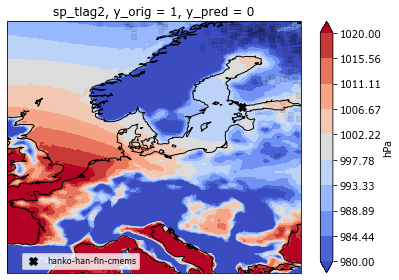

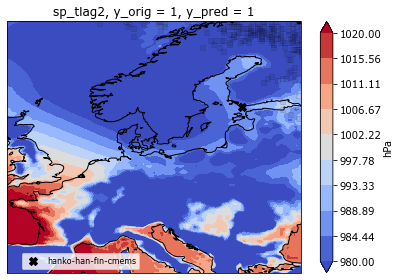

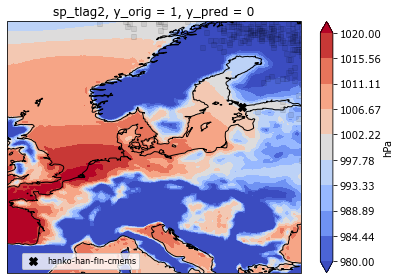

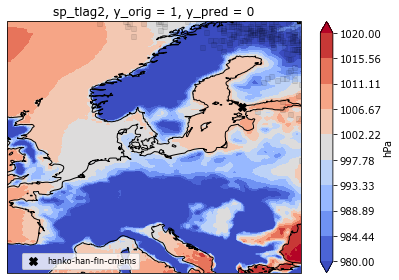

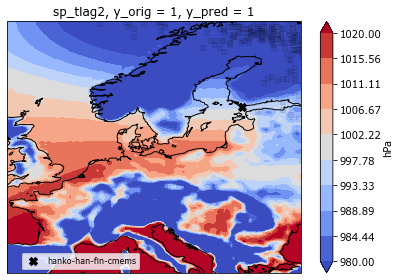

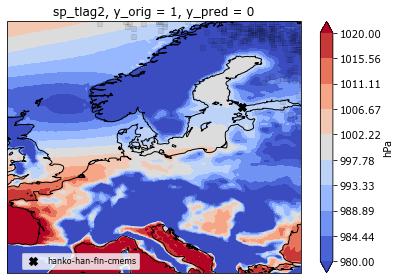

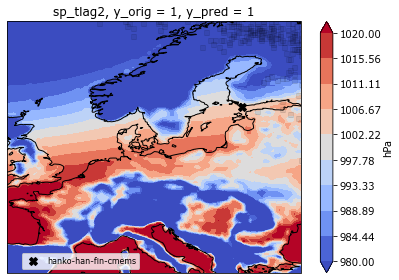

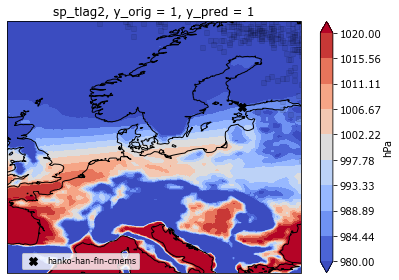

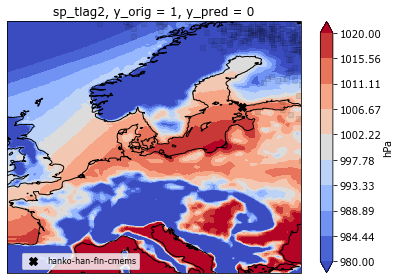

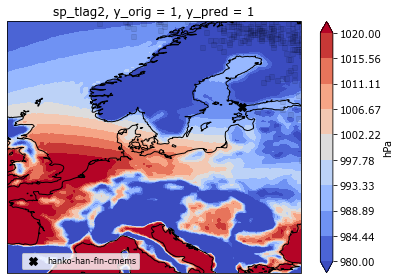

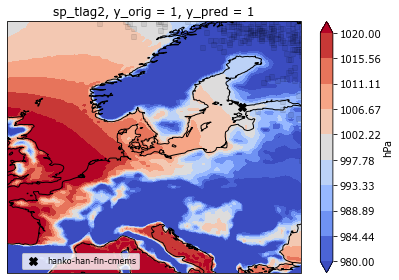

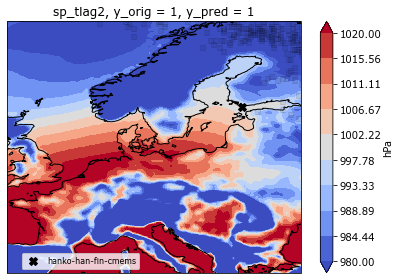

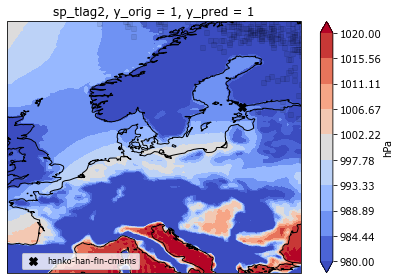

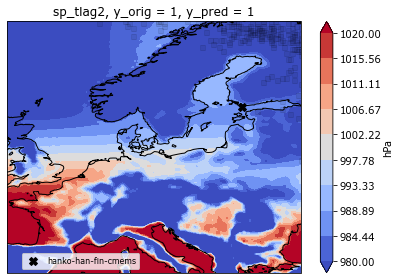

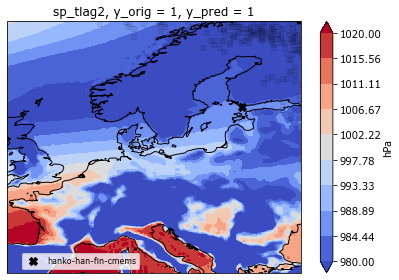

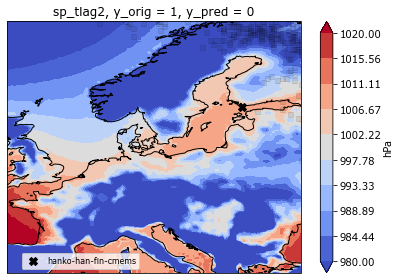

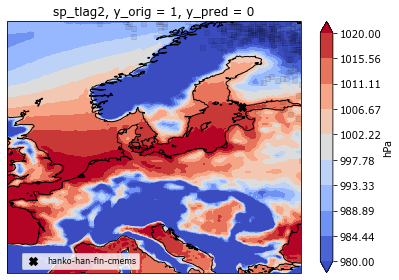

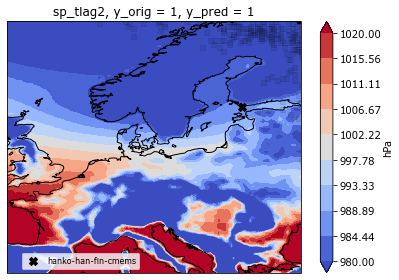

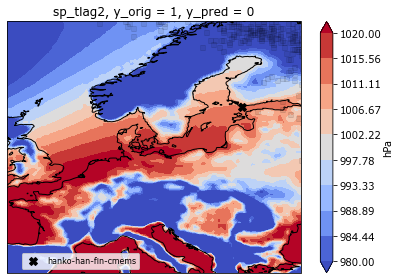

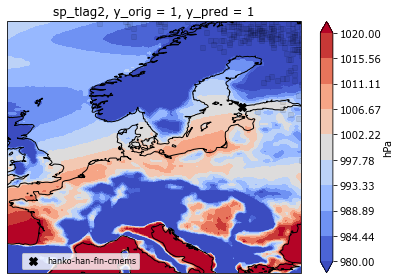

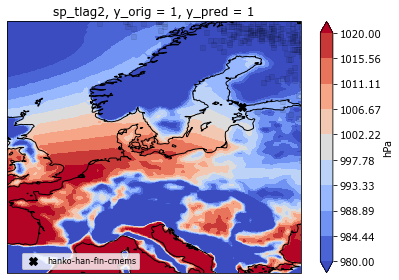

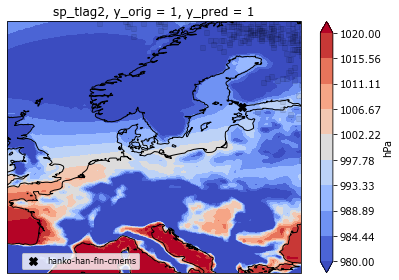

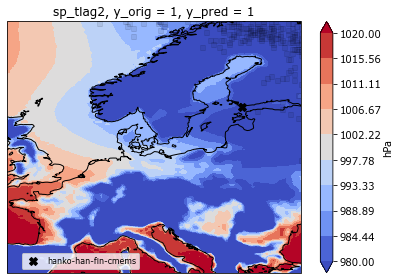

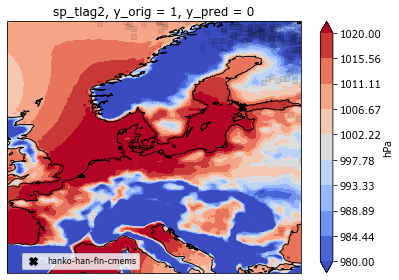

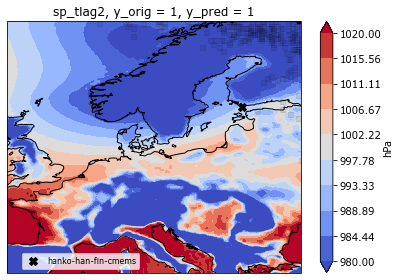

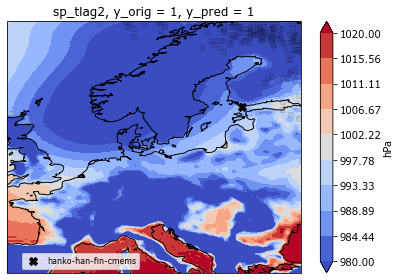

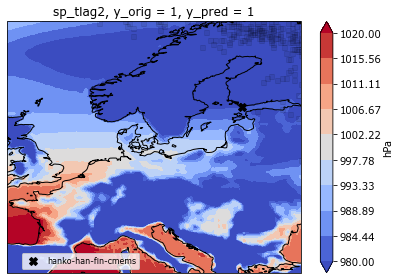

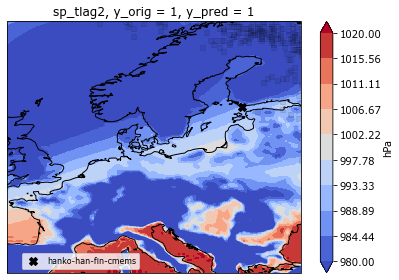

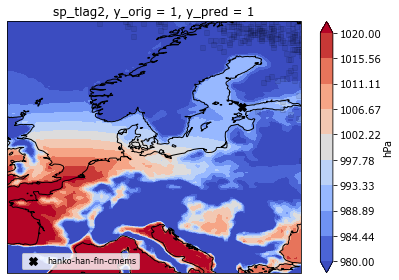

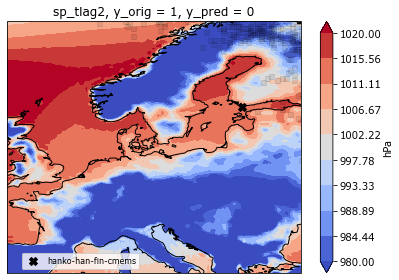

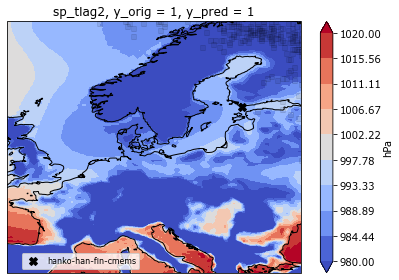

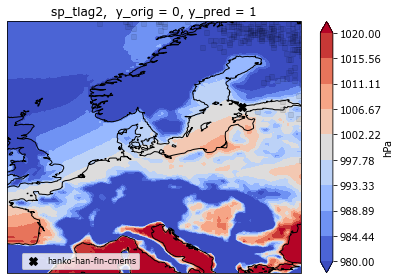

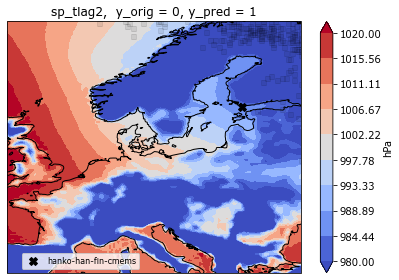

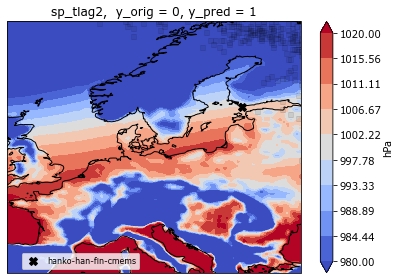

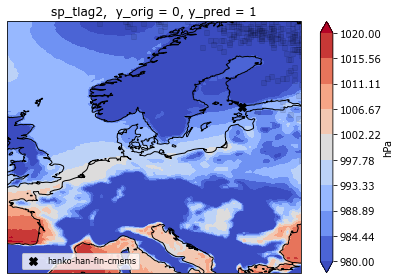

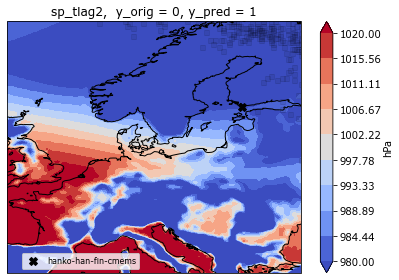

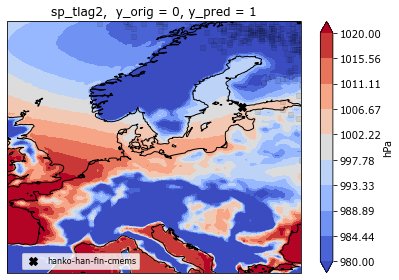

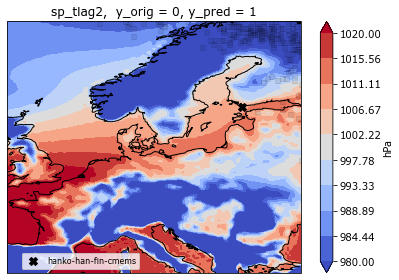

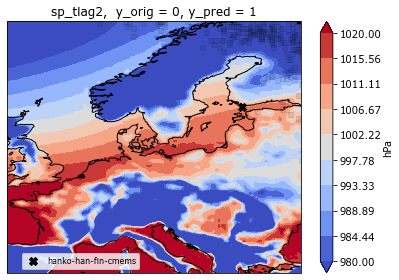

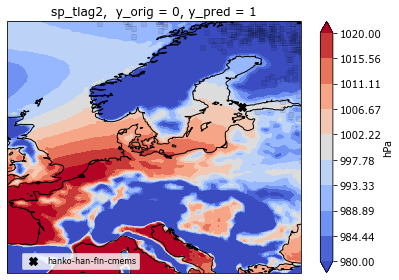

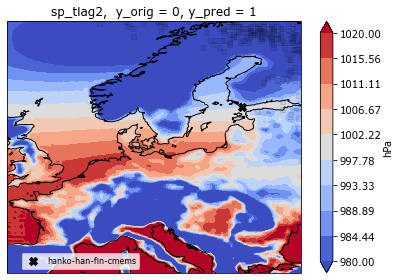

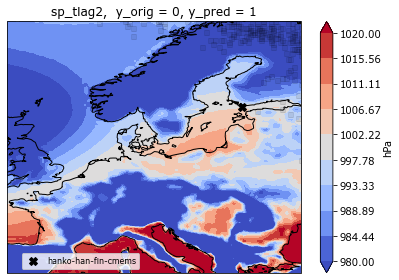

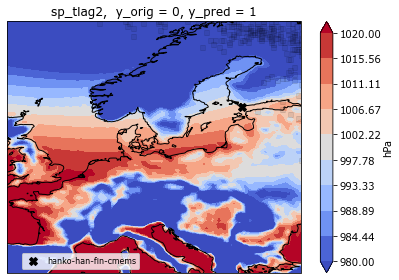

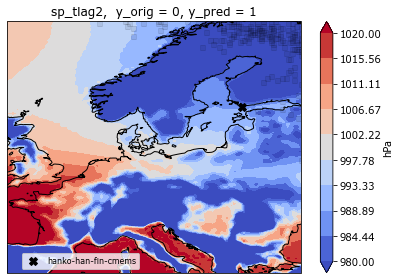

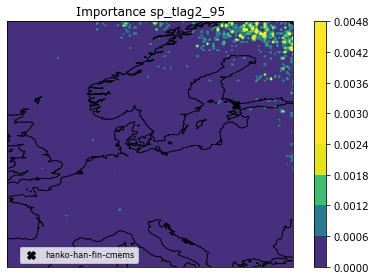

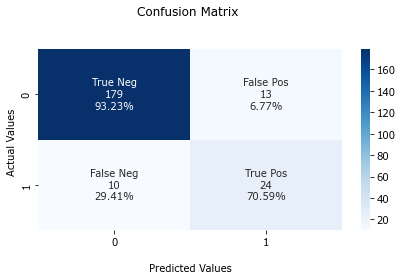

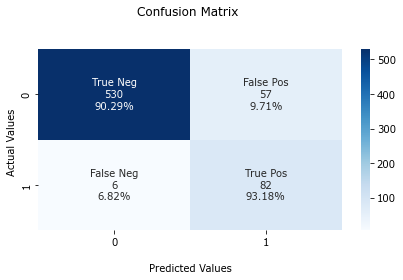

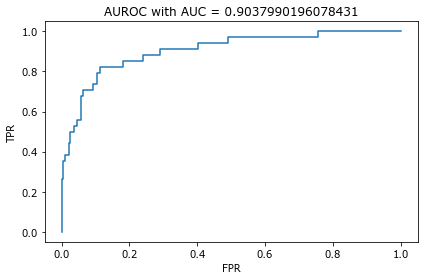

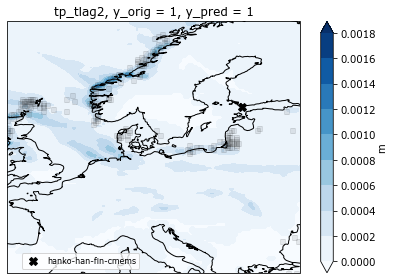

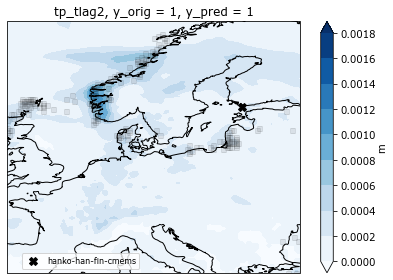

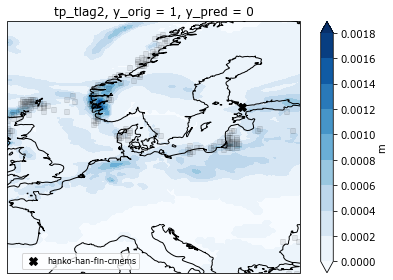

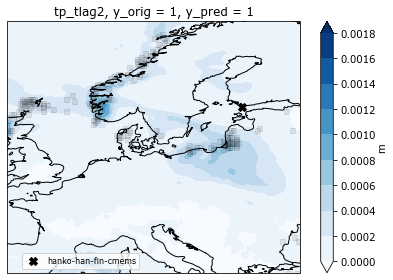

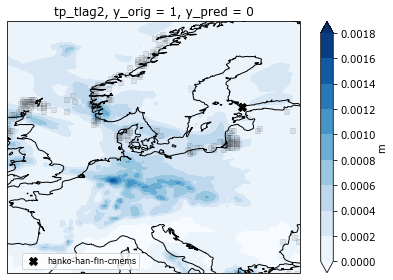

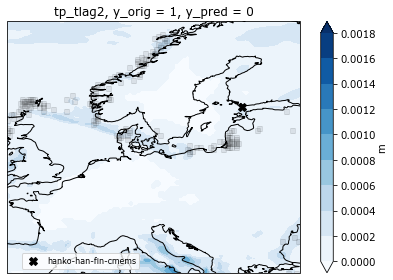

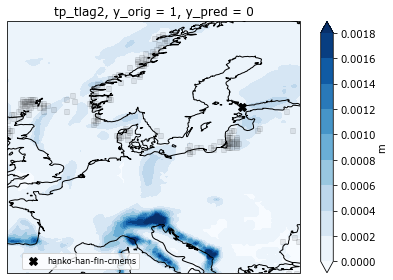

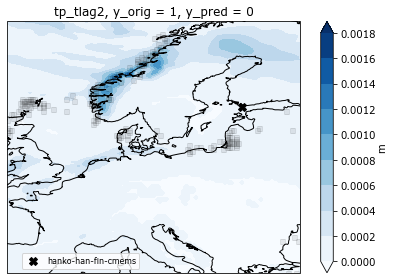

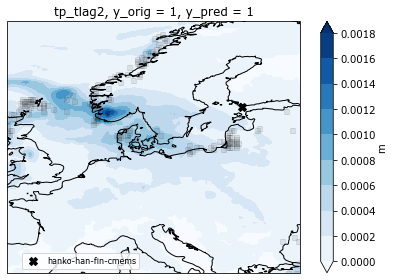

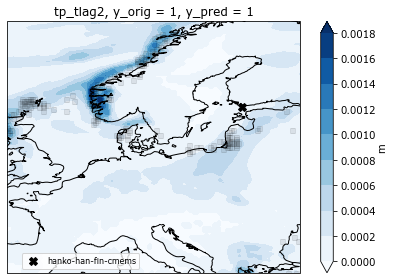

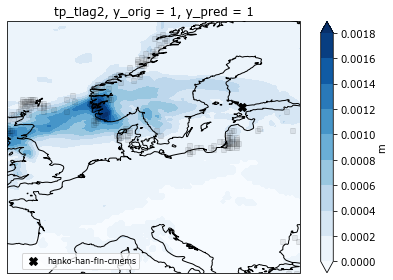

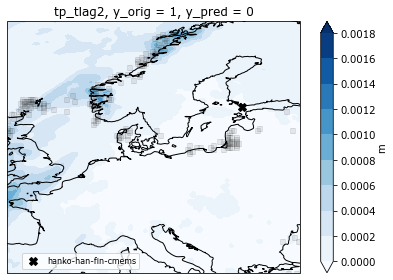

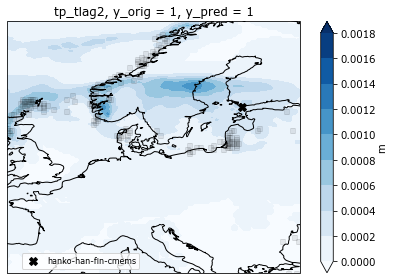

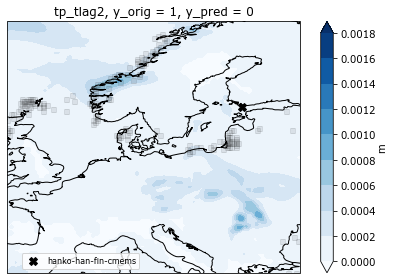

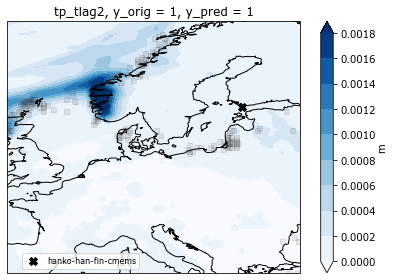

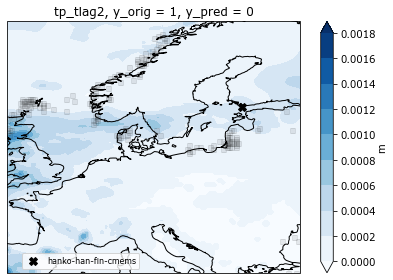

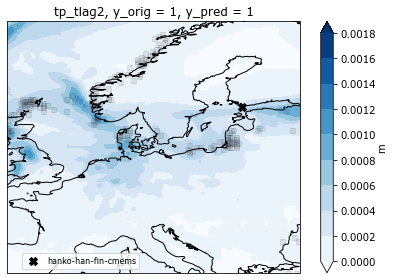

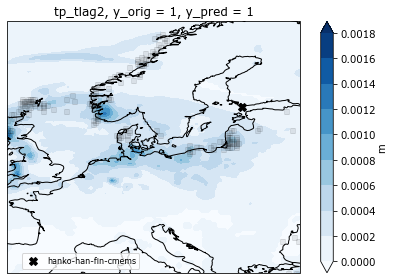

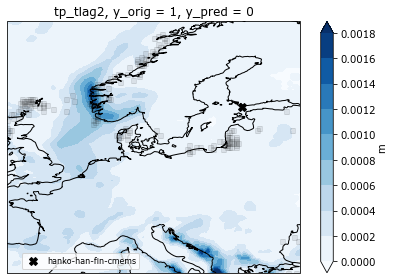

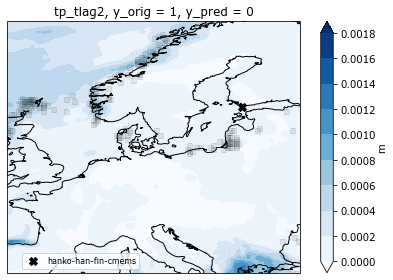

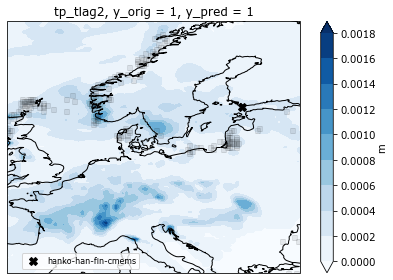

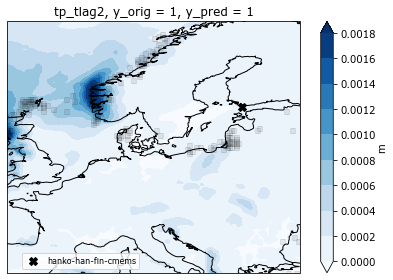

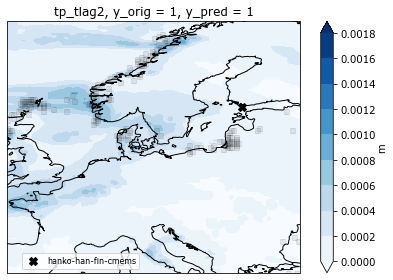

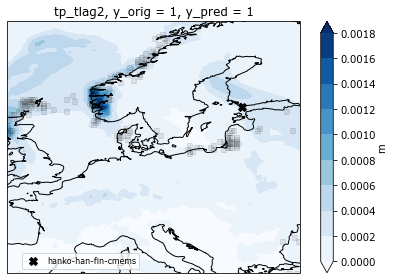

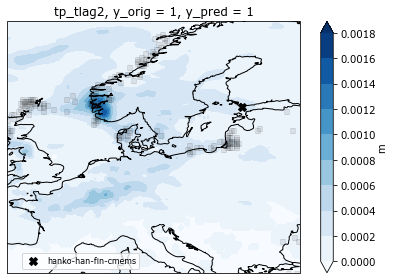

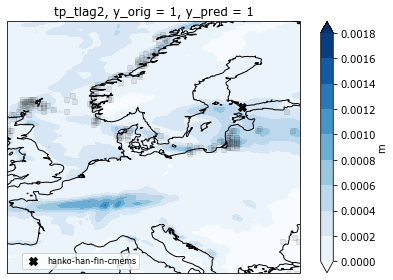

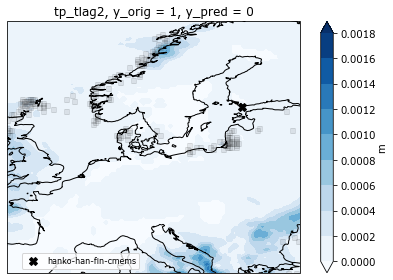

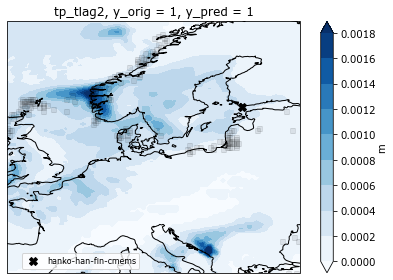

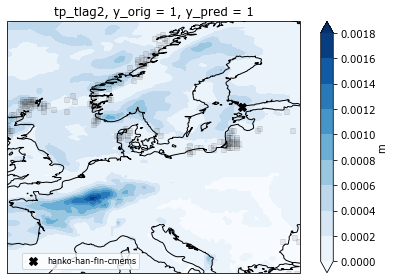

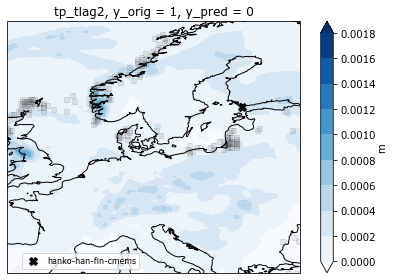

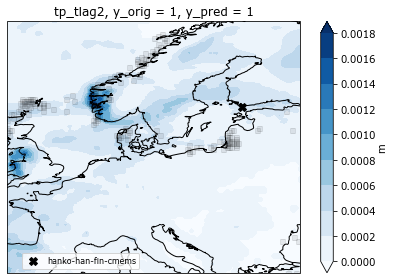

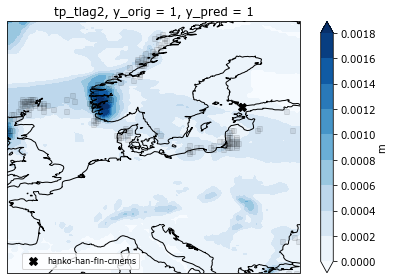

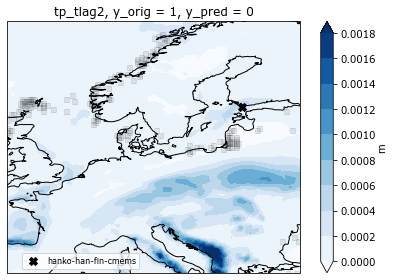

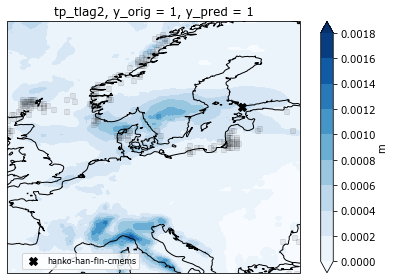

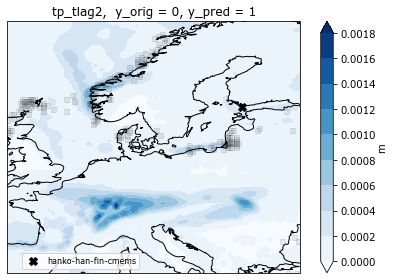

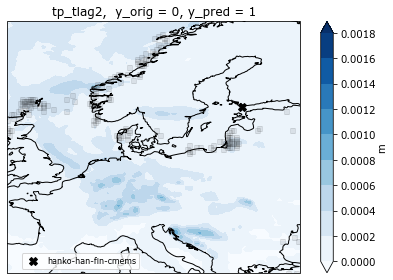

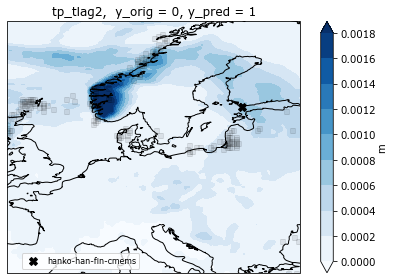

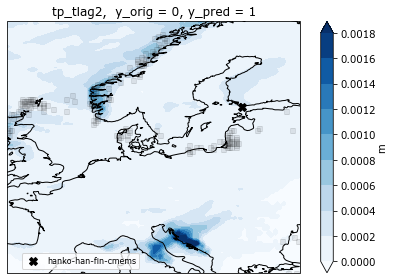

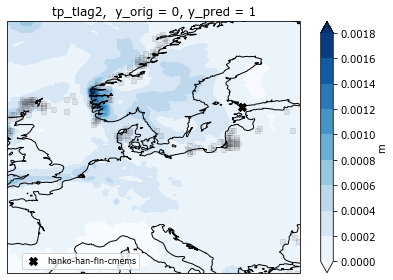

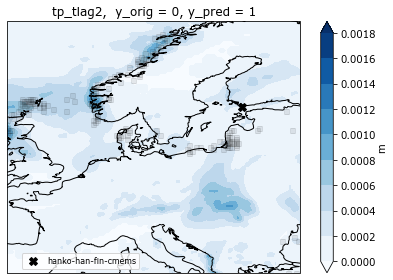

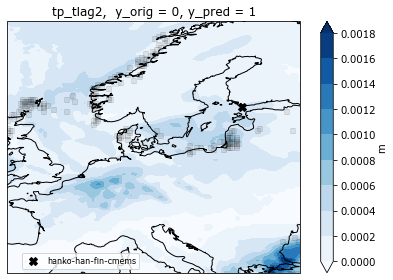

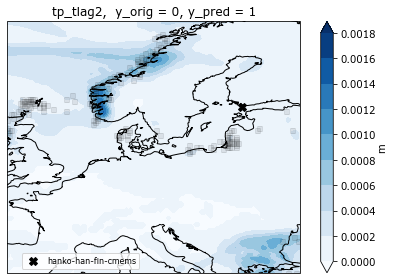

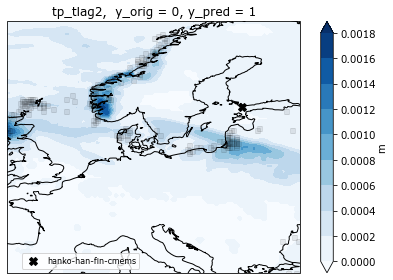

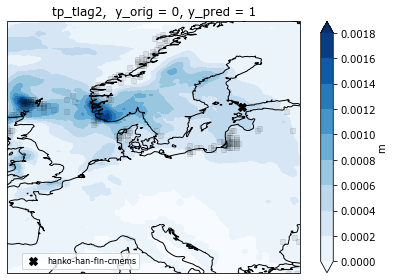

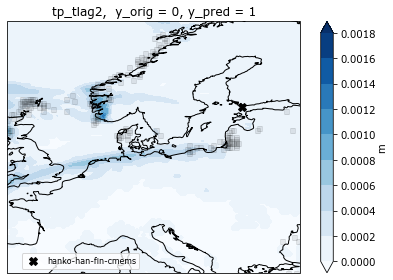

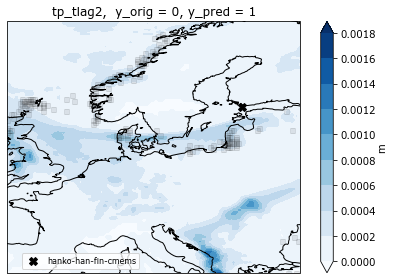

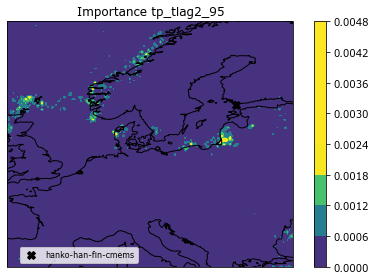

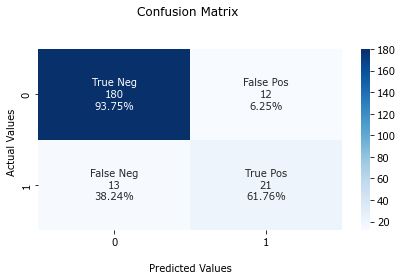

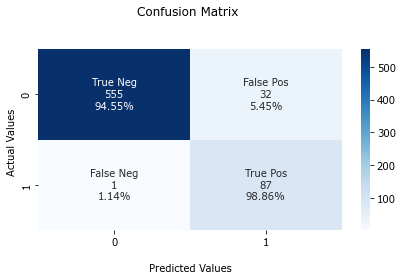

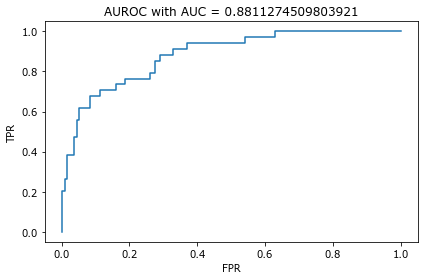

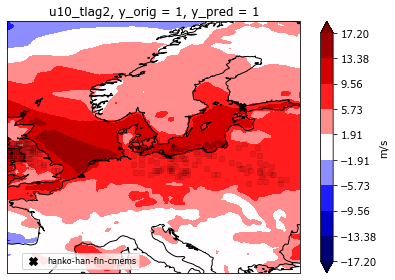

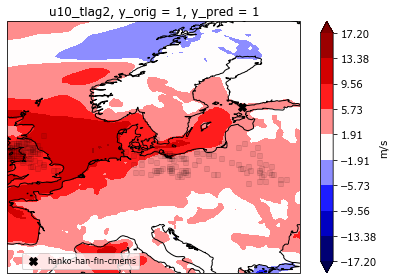

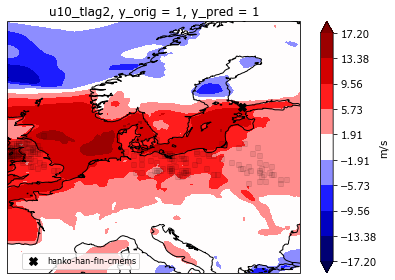

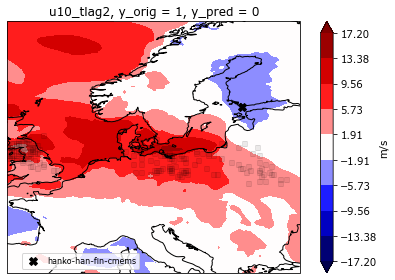

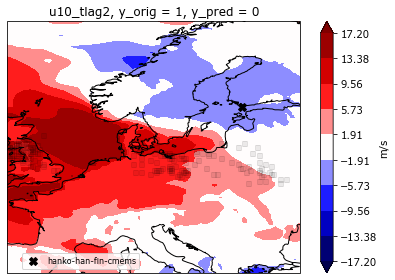

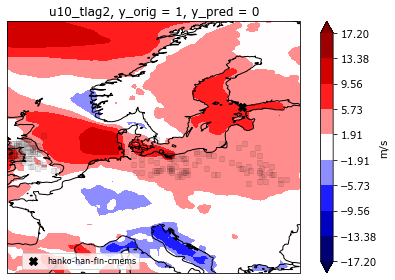

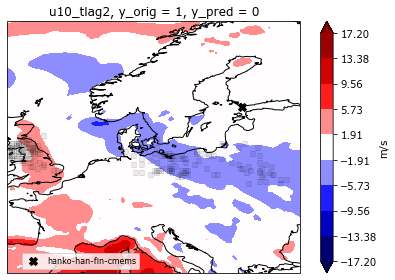

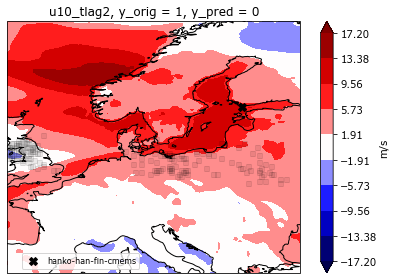

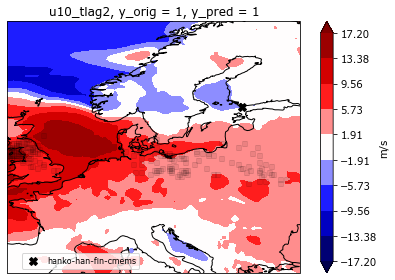

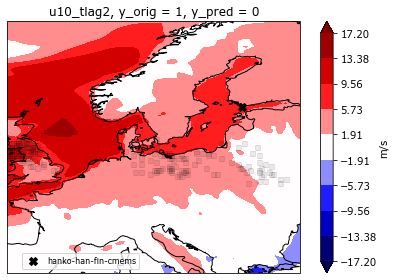

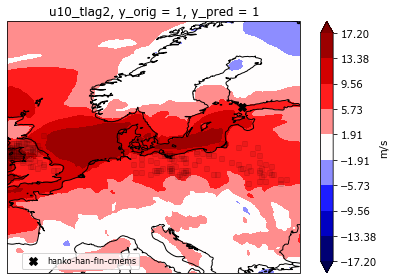

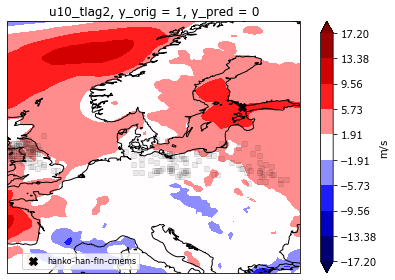

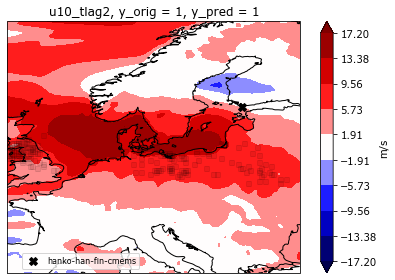

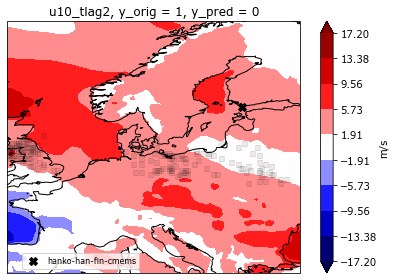

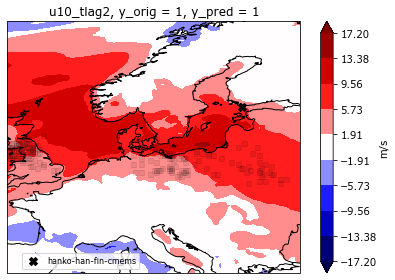

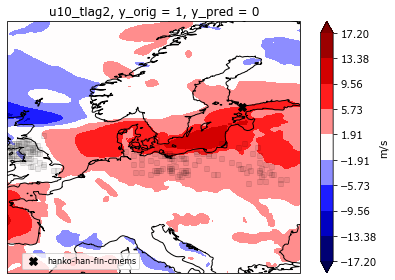

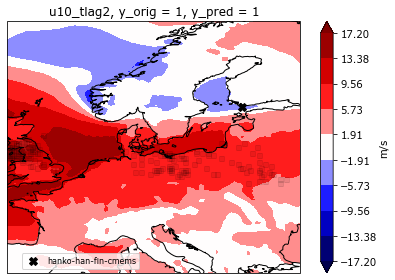

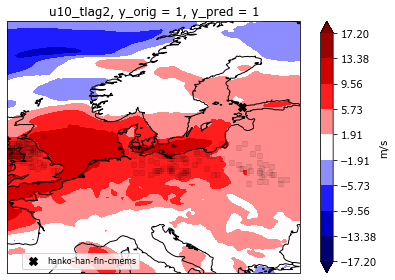

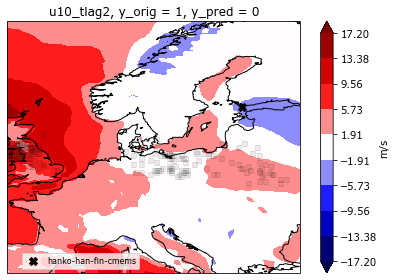

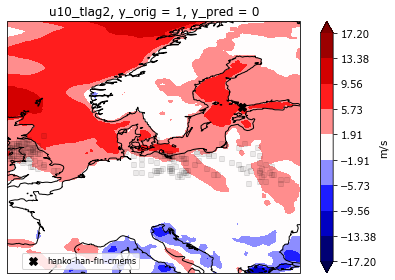

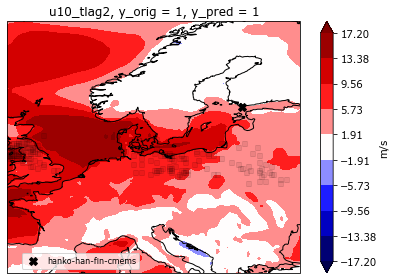

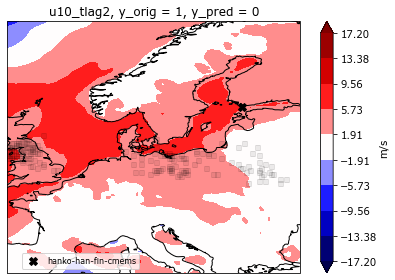

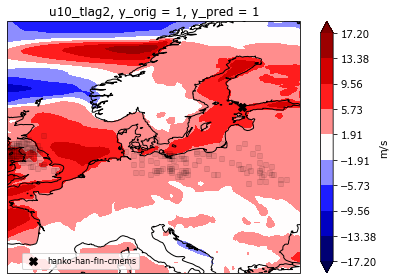

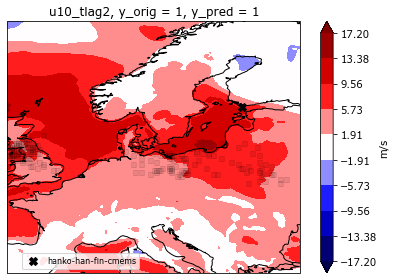

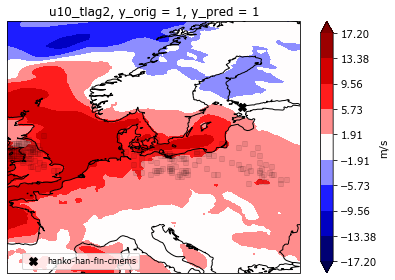

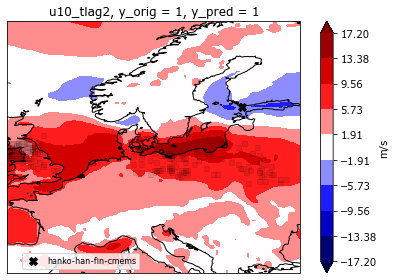

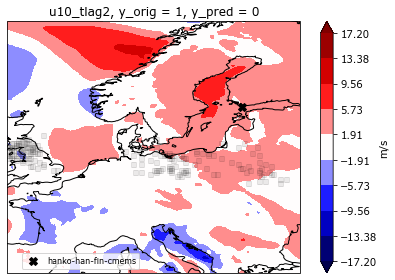

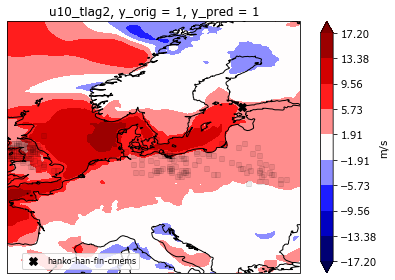

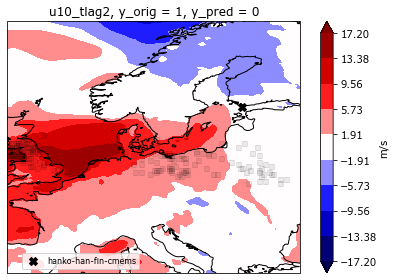

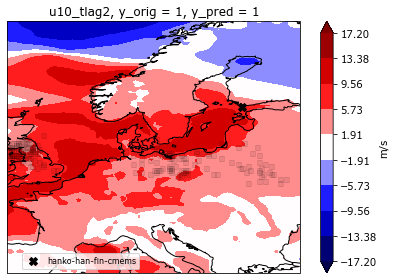

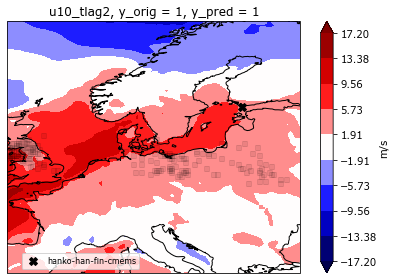

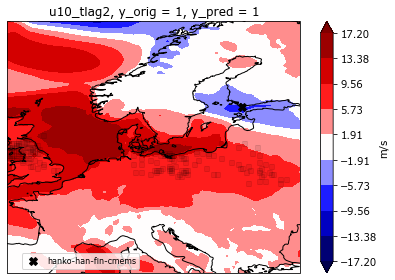

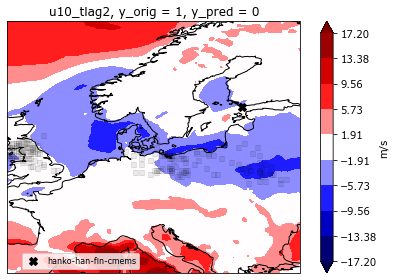

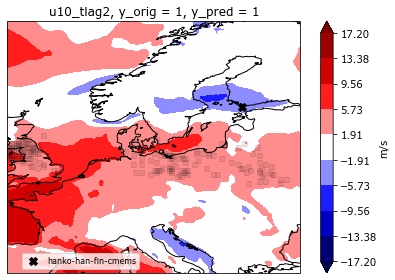

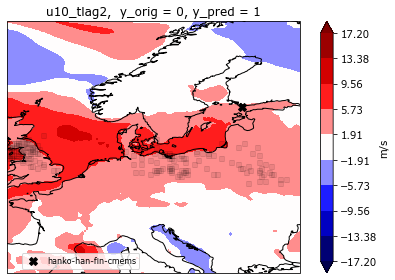

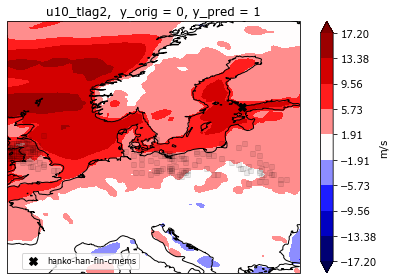

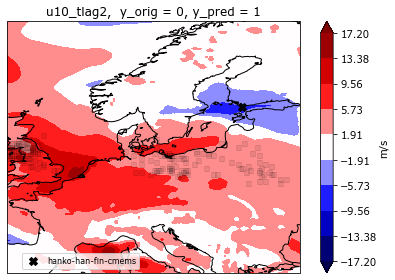

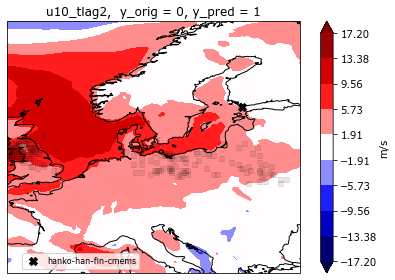

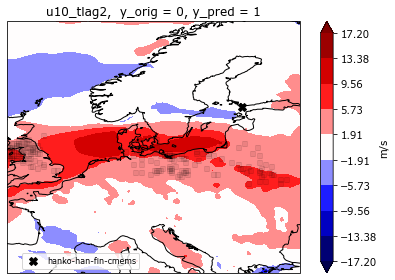

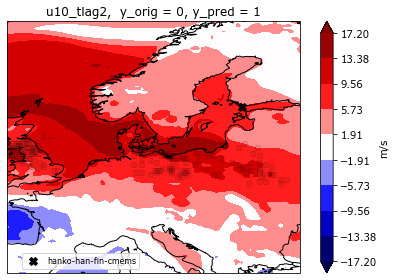

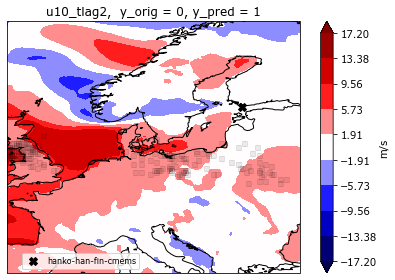

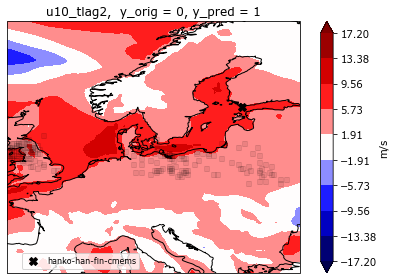

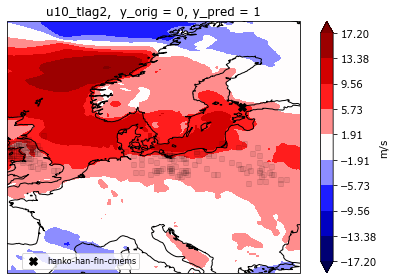

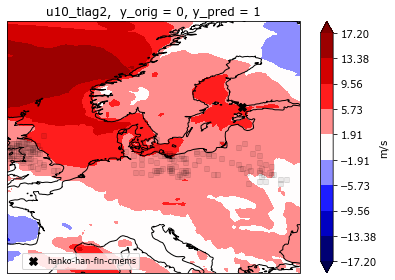

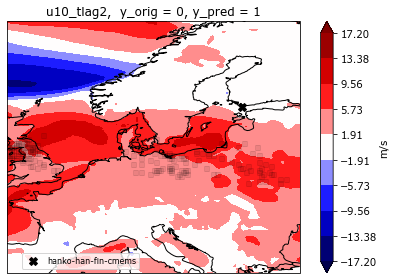

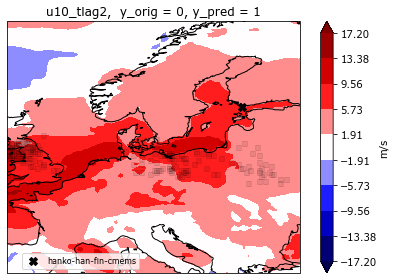

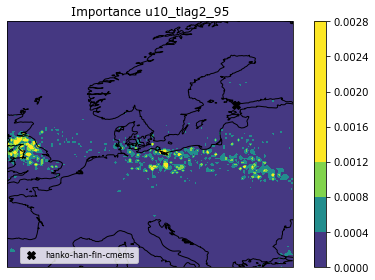

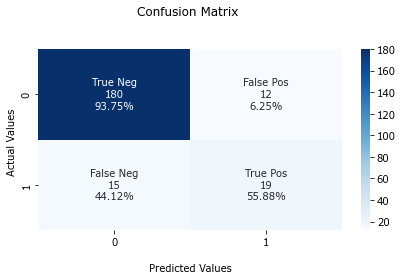

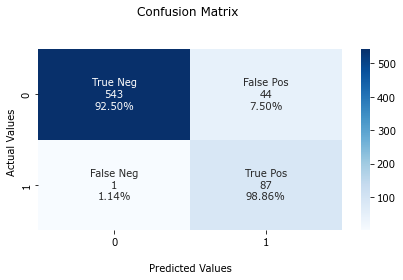

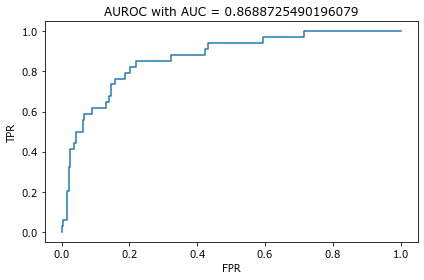

In [8]:
from models.random_forest import rf012

rf012.run(
model_run, 
run_id, 
season,
station_names, 
predictors_of_model, 
timelags_of_model, 
models_path, 
percentile, 
clf, 
hparam_grid, 
optimizer, 
k, 
n_iter, 
random_state,
test_size,
is_optimized, 
is_scaled,
is_overlay_importance,
is_station_name,
)

In [ ]:
#---
# Shutdown PC
#---
import os
os.system("shutdown /s /t 1") 

In [ ]:
# Rf013 tried to simplify random forest. But maxdepth was still at max 10 and results showed possible overfitting.
#RF014 now uses only 1,2,3,4 maxdepth and the rest as default.
